# DICOM RT Tool Tutorial with Open-Access Data

This notebook demonstrates the various functions and utilities available in the Dicom RT tool Python package (https://github.com/brianmanderson/Dicom_RT_and_Images_to_Mask) by Anderson et. al. It serves as supplementary information for the Technical Paper titled: <em>"Simple Python Module for Conversions between DICOM Images and Radiation Therapy Structures, Masks, and Prediction Arrays" </em>. This notebook works through an example of publicly available brain tumor data of T1-w/FLAIR MRI sequences and corresponding RT structure files with multiple segmented regions of interest. Full information of the publicly available brain tumor data used in this notebook can be found at: https://figshare.com/articles/dataset/Data_from_An_Investigation_of_Machine_Learning_Methods_in_Delta-radiomics_Feature_Analysis/9943334. This notebook was written for easy accessibility for beginners to Python programming, medical imaging, and computational analysis. It should take no more than 10-15 minutes to run in it's entirety from scratch. The notebook generates about 10 GB worth of files, so ensure you have adequate space to run it. 

The notebook covers the following topics (click to go to section):
1. [Getting the data](#DATA)
2. [Reading in DICOM and RT struct files and converting to numpy array format](#DICOM)
3. [Saving arrays to nifti format and reloading them](#NIFTI)
4. [Saving and loading numpy files for later use](#NUMPY)
5. [Calculating radiomic features from converted numpy arrays](#RADIOMICS)

The notebook assumes you have the following nested directory structure after running cells that download necessary data:

In [ ]:
"""
Top-level directory/
├── DICOMRTTool_manuscript.ipynb
├── Example_Data/ <- Generated when you run the cells below
|   ├── Image_Data/ 
|       ├── Structure/ <- These correspond to the Pre-RT scans
│           ├── T1/
|               ├── Patient number/
|                   ├── RT Struc file (.dcm) 
│           ├── T2FLAIR/
|               ├── Patient number/
|                   ├── RT Struc file (.dcm)
|       ├── T1/
|           ├── Post1/
|               ├── Patient number/
|                   ├── DICOM image files (.dcm)
|           ├── Post2/
|               ├── Patient number/
|                   ├── DICOM image files (.dcm)
|           ├── Pre/
|               ├── Patient number/
|                   ├── DICOM image files (.dcm) <- The images we care about
|       ├── T2FLAIR/
|           ├── Post1/
|               ├── Patient number/
|                   ├── DICOM image files (.dcm)
|           ├── Post2/
|               ├── Patient number/
|                   ├── DICOM image files (.dcm)
|           ├── Pre/
|               ├── Patient number/
|                   ├── DICOM image files (.dcm) <- The images we care about
├── Data.zip <- Generated when you run the cells below, downloaded Figshare file
├── Nifti_Data/ <- Generated when you run the cells below
|   ├──Image.nii
|   ├──Mask.nii
|   ├──MRN_Path_To_Iteration.xlsx
|   ├──Overall_Data_Examples_(iteration).0.nii.gz 
|   ├──Overall_mask_Examples_y(iteration).0.nii.gz 
├── Numpy_Data/ <- Generated when you run the cells below
|   ├──image.npy
|   ├──mask.npy
"""

In [1]:
%%capture
# Load or install the program, %%capture supresses print statements
!pip install DicomRTTool --upgrade
from DicomRTTool.ReaderWriter import DicomReaderWriter

In [2]:
# importing neccessary libraries 

# file mangagment 
import os 
import zipfile
from six.moves import urllib

# array manipulation and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# medical image manipulation 
import SimpleITK as sitk

## Part 1: Getting the data. <a name="DATA"></a>

The RT struc files and their corresponding DICOM images can be in the same directory or different directories. Here we show a case where structure files and images are located in different directories. This is a good dataset to work with since its somewhat messy but coherent enough to show power of DICOMRTTool. Many files (pre-RT, post-RT at 2 timepoints) but only pre-RT T1 and FLAIR images have associated RT structure files. Downloading and unzipping the necessary files will take about 10 minutes on most CPUs and takes up about 8 GB of storage. One may visualize these DICOM images using a free commercially available DICOM viewer, such as Radiant (https://www.radiantviewer.com/).

In [3]:
%%time
data_path = os.path.join('.', 'Example_Data')
if not os.path.isdir(data_path): # create Example_data directory if it doesn't exist
    os.mkdir(data_path)

url_img = "https://ndownloader.figshare.com/files/20140100" # brain scans 
filename_img = os.path.join(data_path, 'Data.zip')
if not os.path.exists(filename_img): # if zip file doesnt exist download 
    print ("Retrieving zipped images...")
    print('Estimated download time is 5 minutes...')
    urllib.request.urlretrieve(url_img, filename_img)
    print('Finished downloading!')
else:
    print ("Zipped images already downloaded.")

if os.path.exists(filename_img):  # If we downloaded the data
    if not os.path.exists(os.path.join(data_path, 'Image_Data')): # and it hasn't been unzipped
        print ("Unzipping images...")
        print('Estimated unzip time is 2 minutes')
        z = zipfile.ZipFile(filename_img)
        z.extractall(data_path)
        print ("Done unzipping images.")
    
print("All required files downloaded and unzipped!") # print when done

Zipped images already downloaded.
All required files downloaded and unzipped!
Wall time: 2 ms


In [4]:
def display_slices(image, mask, skip=1):
    """
    Displays a series of slices in z-direction that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): Numpy array of image.
            mask (array-like): Numpy array of mask.
            skip (int): Only print every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots).
    """

    slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    counter = 1
    
    for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
        if counter % skip == 0: # if current slice is divisible by desired skip amount 
            masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
            plt.imshow(img_arr, cmap='gray', interpolation='none')
            plt.imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.5, vmin = 1, vmax = np.amax(mask)) # vmax is set as total number of contours so same colors can be displayed for each slice
            plt.show()
        counter += 1

## Part 2: Reading in DICOM and RT struct files and converting to numpy array format. <a name="DICOM"></a>

The principal on which this set of tools operates on is based on the DicomReaderWriter object. It is instantiated with the contours of interest (and associations) and can then be used to create numpy arrays of images and masks of the format [slices, width, height].


The following code logic is used to demonstrate searching a path and returning indices for matched structures and images (by UID) for arbitrary directory structures (DICOM image files and RT Struct files not in the same folder). If all necessary structure files are in the same folder as the corresponding images (by UID), one can alternatively use an os.walk through directories of interest and call DicomReaderWriter each time a folder is discovered. For example, I normally use a folder structure MRN -> date of image (pre,mid,post-RT) -> type of scan (MRI, CT, etc.) -> files (DICOM images + RT Struct). However, this approach calls the DicomReaderWriter iteratively, which can be computationally taxing.

In [5]:
DICOM_path = os.path.join('.', 'Example_Data', 'Image_Data') # folder where downloaded data was stored
print(DICOM_path)

.\Example_Data\Image_Data


This will walk through all of the folders, and using SimpleITK, will separate them based on SeriesInstanceUIDs.

In [6]:
%%time
Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
print('Estimated 1 minutes and 30 seconds')
Dicom_reader.walk_through_folders(DICOM_path) # need to define in order to use all_roi method

Estimated 1 minutes and 30 seconds
Index 0, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\001
Index 1, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\002
Index 2, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\003
Index 3, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\004
Index 4, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\005
Index 5, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\006
Index 6, description ax T1 3D 1MM fSPGR +C  at .\Example_Data\Image_Data\T1\Pre\007
Index 7, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\008
Index 8, description None at None
Index 9, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\010
Index 10, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\011
Index 11, description ax T1 3D 1MM  +c at .\Example_Data\Image_Data\T1\Pre\012
Index 12, description Ax T2Fl

In [7]:
all_rois = Dicom_reader.return_rois(print_rois=True)  # Return a list of all rois present, and print them

The following ROIs were found
exprtfrontrecgli
rtfrontrecglioma
brainstem1
dose 500[cgy]
dose 1200[cgy]
dose 1000[cgy]
body
gtvplus2
exprttempglioma
rttempglioma
brainstem
exprtfrontrecgbm
rtfrontrecgbm
explttempglioma
lttempglioma
dose 2400[cgy]
expltfrontgbm
ltfrontgbm
eye, left
lens, right
lens, left
ltparrecglioma
chiasm
optic nerve, rig
optic nerve, lef
expltparrecgliom
eye, right
expltfrontrecao
ltfrontrecao
dose 2500[cgy]
rttemprecglioma
exprttemprecglio
expinfrttemprecg
infrttempgbm
rttemprecgbm
exprttemprecgbm
exprtfrparresxn
right_front_par_
abv
abv_roi
expltfrparrecgbm
ltfrparrecgbm


In [8]:
# Print the locations of all RTs with a certain ROI name, automatically lower cased
Dicom_reader.where_is_ROI(ROIName='BrAiNsTeM1')

Contours of brainstem1 are located:
.\Example_Data\Image_Data\Structure\T1\001\RS.CA1756_T13D.dcm
.\Example_Data\Image_Data\Structure\T1\011\RS.GF6065_T13D.dcm
.\Example_Data\Image_Data\Structure\T2Flair\001\RS.CA1756_T2Flair.dcm
.\Example_Data\Image_Data\Structure\T2Flair\011\RS.GF6065_T2Flairdcm.dcm
.\Example_Data\Image_Data\T1\001\RS.CA1756_T13D.dcm


In [9]:
Dicom_reader.which_indexes_have_all_rois()  # Check to see which indexes have all of the rois we want
# Since we haven't defined anything yet, it prompts you to input a list of contour names

You need to first define what ROIs you want, please use .set_contour_names(roi_list)


From these ROIs, we will look for those that describe the following regions of interest: tumor (glioblastoma multiforme only) and high-dose area of radiation therapy. 

In [10]:
Contour_Names = ['tumor', 'high_dose'] 

associations = {'dose 1000[cgy]': 'high_dose', 'dose 1200[cgy]': 'high_dose', # new high dose ROI through association
               'exprtfrontrecgbm': 'tumor', 'rtfrontrecgbm': 'tumor', 'expltfrontgbm': 'tumor', # associating gbms to tumor 
                'ltfrontgbm': 'tumor','infrttempgbm': 'tumor', 'rttemprecgbm': 'tumor',
               'exprttemprecgbm': 'tumor','expltfrparrecgbm': 'tumor', 'ltfrparrecgbm': 'tumor'} 

In [11]:
Dicom_reader.__set_associations__(associations) # for some reason this has to be called before set_countour_names
Dicom_reader.set_contour_names(Contour_Names)

Lacking ['tumor'] in index 0, location .\Example_Data\Image_Data\T1\Pre\001. Found ['exprtfrontrecgli', 'rtfrontrecglioma', 'brainstem1', 'dose 500[cgy]', 'dose 1200[cgy]', 'dose 1000[cgy]', 'body', 'gtvplus2']
Lacking ['tumor'] in index 1, location .\Example_Data\Image_Data\T1\Pre\002. Found ['exprttempglioma', 'rttempglioma', 'brainstem', 'dose 500[cgy]', 'dose 1000[cgy]', 'dose 1200[cgy]', 'body', 'gtvplus2']
Lacking ['tumor'] in index 3, location .\Example_Data\Image_Data\T1\Pre\004. Found ['brainstem', 'dose 1000[cgy]', 'dose 1200[cgy]', 'dose 500[cgy]', 'explttempglioma', 'lttempglioma', 'gtvplus2']
Lacking ['tumor'] in index 5, location .\Example_Data\Image_Data\T1\Pre\006. Found ['eye, left', 'lens, right', 'lens, left', 'ltparrecglioma', 'chiasm', 'optic nerve, rig', 'optic nerve, lef', 'expltparrecgliom', 'brainstem', 'eye, right', 'dose 500[cgy]', 'dose 1000[cgy]', 'dose 1200[cgy]', 'gtvplus2']
Lacking ['tumor'] in index 6, location .\Example_Data\Image_Data\T1\Pre\007. Foun

Note: The module is printing "Found []" because many of the scans (post-1 and post-2 RT) do not have associated structure files. The module recognizes these images exist (unique UIDs) but associated structure files cannot be located for them.

In [12]:
Dicom_reader.which_indexes_have_all_rois()  # Check to see which indexes have all of the rois we want
# Since we haven't defined anything yet, it prompts you to input a list of contour names

The following indexes have all ROIs present
Index 2, located at .\Example_Data\Image_Data\T1\Pre\003
Index 4, located at .\Example_Data\Image_Data\T1\Pre\005
Index 9, located at .\Example_Data\Image_Data\T1\Pre\010
Index 10, located at .\Example_Data\Image_Data\T1\Pre\011
Index 14, located at .\Example_Data\Image_Data\T2Flair\Pre\003
Index 16, located at .\Example_Data\Image_Data\T2Flair\Pre\005
Index 20, located at .\Example_Data\Image_Data\T2Flair\Pre\009
Index 21, located at .\Example_Data\Image_Data\T2Flair\Pre\010
Index 22, located at .\Example_Data\Image_Data\T2Flair\Pre\011


In [13]:
pt_indx = 9
Dicom_reader.set_index(pt_indx)  # This index has all the structures, corresponds to pre-RT T1-w image for patient 010
Dicom_reader.get_images_and_mask()  # Load up the images and mask for the requested index

Loading images for ax T1 3D 1MM  +c at 
 .\Example_Data\Image_Data\T1\Pre\010



In [14]:
image = Dicom_reader.ArrayDicom # image array
mask = Dicom_reader.mask # mask array
dicom_sitk_handle = Dicom_reader.dicom_handle # SimpleITK image handle
mask_sitk_handle = Dicom_reader.annotation_handle # SimpleITK mask handle

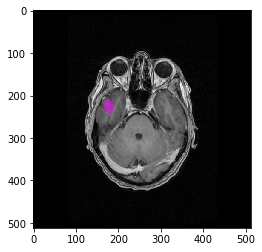

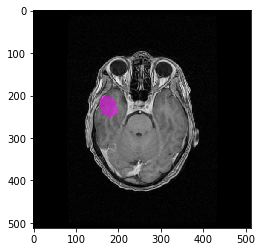

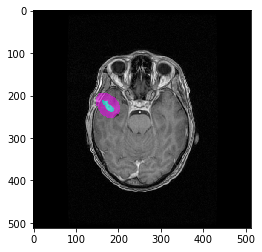

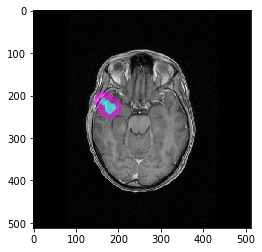

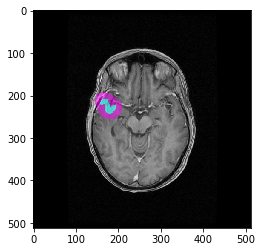

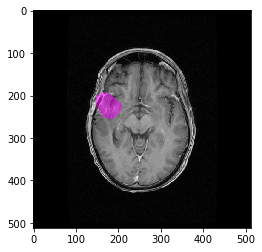

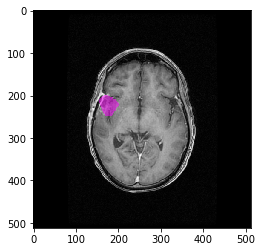

In [15]:
n_slices_skip = 4
display_slices(image, mask, skip = n_slices_skip) # visualize that our segmentations were succesfully convereted 

Note: Cyan color denotes tumor magenta denotes surrounding area of high-dose radiation. Only displaying 7 slices.

## Part 3: Saving arrays to nifti format. <a name="NIFTI"></a>

If you want to use a manual approach, you can view the nifti files easily after running get_images_and_mask(). Saving files as nifti is advisable since spacing information is preserved.

In [16]:
nifti_path = os.path.join('.', 'Example_Data', 'Nifti_Data') # nifti subfolder 
if not os.path.exists(nifti_path):
    os.makedirs(nifti_path)

In [17]:
dicom_sitk_handle = Dicom_reader.dicom_handle # SimpleITK image handle
mask_sitk_handle = Dicom_reader.annotation_handle # SimpleITK mask handle
sitk.WriteImage(dicom_sitk_handle, os.path.join(nifti_path, 'Image.nii'))
sitk.WriteImage(mask_sitk_handle, os.path.join(nifti_path, 'Mask.nii'))

One can also use the built in .write_parallel attribute to generate nifti files for all relevant pairs the DicomReaderWriter object has found/generated. In this case there are 9 image/mask pairs for unique UIDs that contain all contours we are interested in. Note the nifti writer creates a log .txt file in each DICOM folder and a corresponding log excel file in the specified output path. The nifti files are written in the following format: Overall_Data_Examples_index.iteration.0.nii.gz (image) or "Overall_mask_Examples_yindex.iteration.0.nii.gz" (mask).

In [18]:
%%time
%%capture
Dicom_reader.write_parallel(out_path = nifti_path, excel_file = os.path.join(nifti_path,'.','MRN_Path_To_Iteration.xlsx'))

Wall time: 1min 11s


We can now reload the nifti files and disaply them to check that nothing went wrong. You can inspect the other converted files by changing the numerical suffix as per the excel log file ('MRN_Path_To_Iteration.xlsx'). In this case iteration 2 corresponds to the patient we are interested in.

In [19]:
nifti_image = sitk.ReadImage(os.path.join(nifti_path,"Overall_Data_Examples_"+str(2)+".0.nii.gz")) # reload image
image = sitk.GetArrayFromImage(nifti_image)
nifti_mask = sitk.ReadImage(os.path.join(nifti_path,"Overall_mask_Examples_y"+str(2)+".0.nii.gz")) # reload mask
mask = sitk.GetArrayFromImage(nifti_mask)

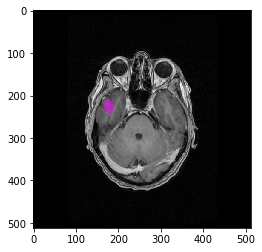

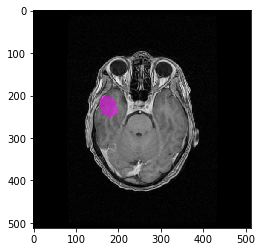

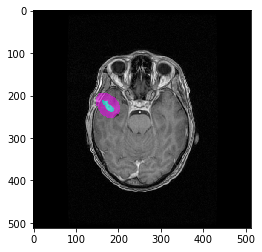

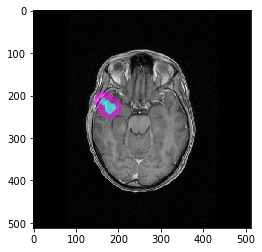

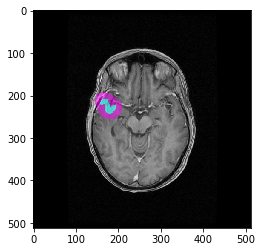

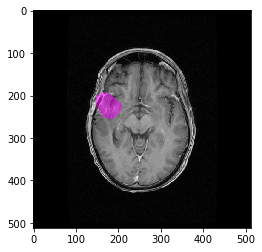

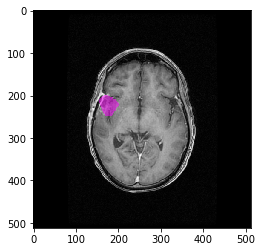

In [20]:
display_slices(image, mask, skip = n_slices_skip) # visualize that our segmentations were succesfully convereted from nifti 

## Part 4: Saving and loading numpy files for later use. <a name="NUMPY"></a>

Finally we can save the numpy arrays themselves to files for later use (so you don't have to reinstantiate the computationally expensive DicomReaderWriter object) and subsequently re-load the numpy arrays.

In [21]:
numpy_path = os.path.join(data_path, 'Numpy_Data') # go into numpy subfolder 
if not os.path.exists(numpy_path):
    os.makedirs(numpy_path)

In [22]:
np.save(os.path.join(numpy_path, 'image'), image) # save the arrays
np.save(os.path.join(numpy_path, 'mask'), mask)

In [23]:
image = np.load(os.path.join(numpy_path,'image.npy')) # load the arrays
mask = np.load(os.path.join(numpy_path,'mask.npy'))

## Part 5: Radiomics Use-case Example. <a name="RADIOMICS"></a>

Here we use the popular open-source radiomics library PyRadiomics (https://pyradiomics.readthedocs.io/en/latest/) to calculate radiomic features for our ROIs. In this case, we only calculate a limited number features from the tumor as an illustrative example. 

In [24]:
try:
    from radiomics import featureextractor
except:
    !pip install pyradiomics
    from radiomics import featureextractor

In [25]:
%%time
# note: need sitk images (sitk.ReadImage(nifti file)) to plug into PyRadiomics, preserves spacing 

ROI_index = 2 # index for tumor
nifti_mask_tumor = sitk.BinaryThreshold(nifti_mask, lowerThreshold=ROI_index, upperThreshold=ROI_index) # select only ROI of interest

params = {} # can edit in more params as neccessary 
extractor = featureextractor.RadiomicsFeatureExtractor(**params) # instantiate extractor with parameters 
extractor.disableAllFeatures() # in case where only want some features, can delete disable/enable lines if you want deafult
extractor.enableFeatureClassByName('firstorder') 
extractor.enableFeatureClassByName('glcm') 
features = {} # empty dictionary 
features = extractor.execute(nifti_image, nifti_mask_tumor) # unpack results into features dictionary
df = pd.DataFrame({k: [v] for k, v in features.items()}) # put dictionary into a dataframe 

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Wall time: 7.76 s


In [26]:
pd.set_option('display.max_columns', None)

In [27]:
df # display dataframe to inspect features 

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares
0,v3.0,1.18.5,1.2.4,1.1.1,3.7.6,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e8213d50c36a0729730c48358bd210cccc89396b,3D,"(0.5859000086784363, 0.5859000086784363, 1.0)","(512, 512, 192)",147.308186,0.0,2212.0,fa1c4c54ba19168fc33ee824bfddfb37b8d0d9bd,"(0.5859000086784363, 0.5859000086784363, 1.0)","(512, 512, 192)","(144, 191, 66, 66, 66, 31)",53782,1,"(176.03623889033506, 223.6755605964821, 82.564...","(-46.56736683885528, -19.38449174403891, 3.659...",589.0,1087.0,39883318664.0,5.0182490374409605,190.0,5.383829382007247,1863.0,154.8557752436467,831.3496708936075,810.0,0.0,1863.0,85.18889099373658,861.1467563062456,0.6404905940571037,13691098575.417799,0.044577574730726585,50431.4606018589,1202.5209302051046,482895.29659568606,3448.037895425249,294.74361805795974,25.90107974539547,0.8383945189523667,3.1111912199563045,3.179129763661805,15.729607940779077,0.4285107456733146,0.3598781715378478,0.9956063458725701,0.9624123779162571,-0.236646966105915,0.9443620984093853,0.34245161402614194,33.694340035552315,0.005883390930668868,8.818373864758065,0.8485146967882806,0.019788453570843818,67.38868007110457,5.937031813923166,80.16117445083886


Numerical results for radiomic features shown here are consistent with importing nifti files as image and label map in 3D Slicer (https://www.slicer.org/) and using Radiomics extension (https://www.slicer.org/wiki/Documentation/Nightly/Extensions/Radiomics).  